FIR　EEG-ECoG 共通 EEG 予測 共通

1. FIR 0, IIR 1, LSTM 2
2. EEG-ECoG間でフィルター共通 0, バラバラ 1
3. 予測対象 EEG 0, ECoG 1
4. 予測の仕方 共通 0, NNをわける（フォルター特性が変わる） 1



## 別の学習則をもう一度だけ試す

In [4]:
# -*- coding: utf_8 -*-  
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

import copy
import json
import pandas as pd
import numpy as np
import datetime
import math
import time

import chainer
from chainer import cuda, Function, gradient_check, utils, Variable
from chainer import optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from scipy import signal


import pickle
import sys
import random
import h5py

import iir_class

In [5]:
test=h5py.File('Ma/DeepANES.mat')

ECoG = np.array(test['ECoG'])
EEG = np.array(test['EEG'])
EEG = np.delete(EEG, 14, axis=1)
EEG = EEG.astype('float32')
ECoG = ECoG.astype('float32')

In [35]:
order = 5
time_range = 1000

train_time = [1000, time_range+1000]
hamming = signal.hamming(train_time[1]-train_time[0])
#training ぶんだけにする
#EEG_t = np.zeros((EEG.shape[0]-order+1, EEG.shape[1], order))
#ECoG_t = np.zeros((ECoG.shape[0]-order+1, ECoG.shape[1], order))
EEG_t = np.zeros((train_time[1]-train_time[0], EEG.shape[1], order))
ECoG_t = np.zeros((train_time[1]-train_time[0], ECoG.shape[1], order))
EEG_tmp = EEG[train_time[0]:train_time[1], :] *np.array([hamming]*EEG.shape[1]).T
ECoG_tmp = ECoG[train_time[0]:train_time[1], :] *np.array([hamming]*ECoG.shape[1]).T
for t in range(order):
    for ch in range(EEG.shape[1]):
        #EEG_t[:,ch,t] = EEG[:EEG.shape[0]-order+1, ch] 
        EEG_t[t:,ch,t] = EEG_tmp[:time_range-t, ch] 
    for ch in range(ECoG.shape[1]):
        #ECoG_t[:,ch,t] = ECoG[:ECoG.shape[0]-order+1, ch] 
        ECoG_t[t:,ch,t] = ECoG_tmp[:time_range-t, ch] 
EEG_t = Variable((EEG_t).astype('float32'))
ECoG_t = Variable((ECoG_t).astype('float32'))

In [37]:
def calNN(timeSpacePerceptron, EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, loop=200):
    loss_history = np.zeros((loop, 1))
    optimizer = optimizers.AdaDelta()
    #optimizer = optimizers.AdaDelta()
    optimizer.setup(timeSpacePerceptron)
    optimizer.add_hook(chainer.optimizer.WeightDecay(0.05))
    #optimizer.add_hook(chainer.optimizer.Lasso(0.5))
    #optimizer.add_hook(chainer.optimizer.GradientClipping(0.5))
    timeSpacePerceptron.zerograds()
    for i in range(loop):
        timeSpacePerceptron.zerograds()
        x1, x2, EEG_filtered_prev, ECoG_filtered_prev = timeSpacePerceptron(EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, train=True)
        #loss = F.cross_covariance(x1, x2)
        loss = F.mean_squared_error(x1, x2)
        loss.backward()
        optimizer.prepare()
        optimizer.update()
        loss_history[i] = loss.data
    return timeSpacePerceptron, loss_history, EEG_filtered_prev, ECoG_filtered_prev, x1, x2

In [38]:
def loop_calNN(EEG_t, ECoG_t, data_type, loop=200, loop_num=20):
    EEG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
    ECoG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ
    saved_data = dict()
    #outout = []
    out_loss_history = []
    for n in range(loop_num):
        out = []
        loss_history = np.zeros((loop, 1))
        timeSpacePerceptron = iir_class.__dict__["TimeSpacePerceptron{0}".format(data_type)](time_range)
        timeSpacePerceptron, loss_history, EEG_filtered_prev, ECoG_filtered_prev, x1, x2 = calNN(timeSpacePerceptron, EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, loop=loop)
        out_loss_history.append(loss_history)
        #outout.append(timeSpacePerceptron)
    saved_data['loss_history'] = out_loss_history
    saved_data['NN'] = timeSpacePerceptron
    #saved_data['NN'] = outout
    return saved_data, EEG_filtered_prev, ECoG_filtered_prev

In [56]:
saved_data = dict()
loop = 1500
loop_num = 1
st = time.time()

In [57]:
# channle をわけない
data_type ='1000'

saved_data[data_type],  EEG_filtered_prev, ECoG_filtered_prev =  loop_calNN(EEG_t, ECoG_t, data_type, loop=loop, loop_num=loop_num)

#for i in range(10):
x1, x2, EEG_filtered_prev, ECoG_filtered_prev = saved_data[data_type]['NN'](EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, train=False)



print()
print(time.time()-st)


1559.389683008194


In [58]:
#EEG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(EEG.shape[1])] #前の出力をいれるところ　(RNN)
#ECoG_filtered_prev = [Variable(np.zeros((time_range, 1)).astype('float32')) for j in range(ECoG.shape[1])] #前の出力をいれるところ


x1, x2, EEG_filtered_prev, ECoG_filtered_prev = saved_data[data_type]['NN'](EEG_t, ECoG_t, EEG_filtered_prev, ECoG_filtered_prev, train=False)


for ch in range(16):
    print(np.corrcoef(x1.data[:,ch], x2.data[:,ch])[0, 1])

0.980196109464
0.978846468341
0.97107661652
0.978634423637
0.984096808021
0.970921276245
0.984354720831
0.985513728164
0.985208459033
0.978859458479
0.984189783585
0.987377889622
0.986941821033
0.96630352465
0.980166734607
0.966273809992


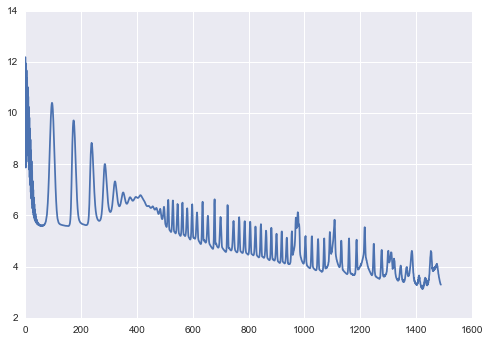

In [59]:
plt.plot(np.log([x for x in saved_data[data_type]['loss_history'][0][10:]]))

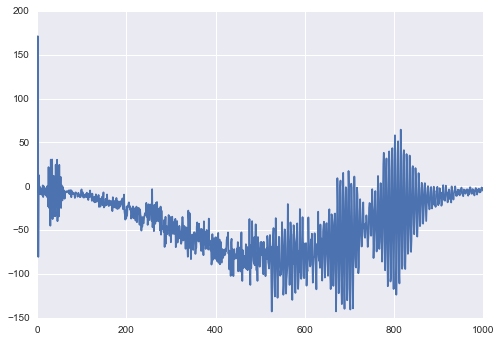

In [69]:
plt.plot(x1.data[:,15])

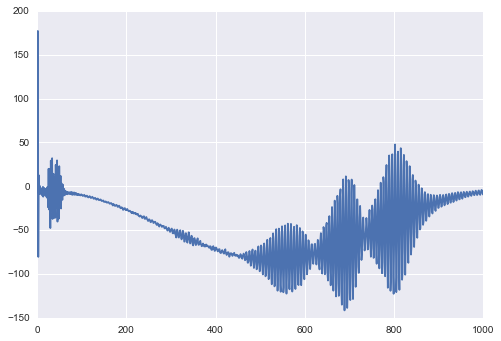

In [70]:
plt.plot(x2.data[:,15])

In [ ]:
# EEG to ECoG
data_type ='1011'
tmp_data = []
coor_val = []
for ch in range(ECoG.shape[1]):
    out, EEG_filtered_prev, ECoG_filtered_prev = loop_calNN(EEG_t, ECoG_t[:, ch, :], data_type, loop=loop, loop_num=loop_num)
    tmp_data.append(out)
    x1, x2, EEG_filtered_prev, ECoG_filtered_prev = out['NN'](EEG_t, ECoG_t[:,ch,:], EEG_filtered_prev, ECoG_filtered_prev, train=False)
    coor_val.append(np.corrcoef(x1.data, x2.data)[0,1])
saved_data[data_type] =  tmp_data
print(time.time()-st)

In [ ]:
plt.plot(x2.data)

23


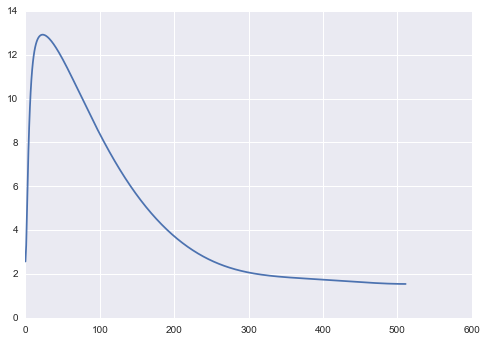

In [63]:
from scipy import signal
w, h = signal.freqz(saved_data[data_type]['NN'].IIR.W.data[0][5:], saved_data[data_type]['NN'].IIR.W.data[0][0:5])
plt.plot(np.abs(h))
print(np.argmax(np.abs(h)))

In [ ]:
plt.plot(out['loss_history'][0])

In [ ]:
from scipy import signal
w, h = signal.freqz(out['NN'].IIR.W.data[0][5:], out['NN'].IIR.W.data[0][0:5])
plt.plot(np.abs(h))

In [ ]:
saved_data[data_type]['NN'].IIR.W.data

In [ ]:
saved_data[data_type]['NN'].transformECoG.W.data

In [ ]:
x1, x2 = saved_data[data_type]['NN']()